# Processing


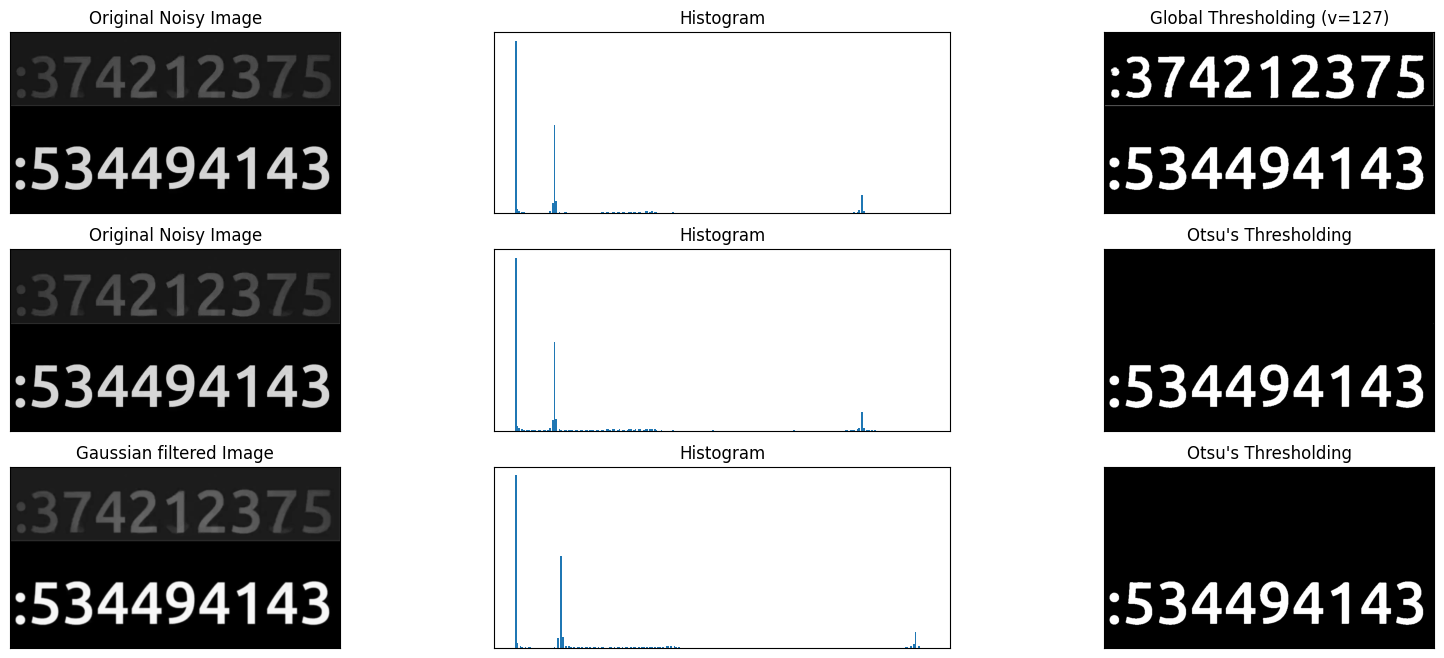

In [1]:
import cv2 as cv
import matplotlib.pyplot as plt


filename = 'extracted_images/brcam_webrtc/img000001.png'

img = cv.imread(filename, cv.IMREAD_GRAYSCALE)

# global thresholding
ret1,th1 = cv.threshold(img,35,255,cv.THRESH_BINARY)
# Otsu's thresholding
ret2,th2 = cv.threshold(img,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)
# Otsu's thresholding after Gaussian filtering
blur = cv.GaussianBlur(img,(5,5),0)
ret3,th3 = cv.threshold(blur,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)
# plot all the images and their histograms
images = [img, 0, th1,
          img, 0, th2,
          blur, 0, th3]

titles = ['Original Noisy Image','Histogram','Global Thresholding (v=127)',
          'Original Noisy Image','Histogram',"Otsu's Thresholding",
          'Gaussian filtered Image','Histogram',"Otsu's Thresholding"]

plt.figure(figsize=(20,8))
for i in range(3):
    plt.subplot(3,3,i*3+1),plt.imshow(images[i*3],'gray')
    plt.title(titles[i*3]), plt.xticks([]), plt.yticks([])

    plt.subplot(3,3,i*3+2),plt.hist(images[i*3].ravel(),256)
    plt.title(titles[i*3+1]), plt.xticks([]), plt.yticks([])

    plt.subplot(3,3,i*3+3),plt.imshow(images[i*3+2],'gray')
    plt.title(titles[i*3+2]), plt.xticks([]), plt.yticks([])
plt.show()

In [2]:
import pytesseract
import re

custom_config = r'--oem 0 --psm 12 --dpi 300 -c tessedit_char_whitelist="0123456789 :"'
data = pytesseract.image_to_data(img, lang='eng', config=custom_config, nice=0, output_type=pytesseract.Output.DICT)
display(data)

matches = []
for i in range(len(data['text'])):
    text = data['text'][i]
    conf = float(data['conf'][i]) / 100
    matched = re.findall(r'\d{9}(?=[\s:]|$)', text)
    for match in matched:
        matches.append((conf, int(match)))

matches

{'level': [1, 2, 3, 4, 5],
 'page_num': [1, 1, 1, 1, 1],
 'block_num': [0, 1, 1, 1, 1],
 'par_num': [0, 0, 1, 1, 1],
 'line_num': [0, 0, 0, 1, 1],
 'word_num': [0, 0, 0, 0, 1],
 'left': [0, 16, 16, 16, 16],
 'top': [0, 330, 330, 330, 330],
 'width': [948, 898, 898, 898, 898],
 'height': [520, 124, 124, 124, 124],
 'conf': [-1, -1, -1, -1, 89],
 'text': ['', '', '', '', ':534494143']}

[(0.89, 534494143)]

In [3]:
import cv2 as cv
import pytesseract
import glob
import re
import multiprocessing
import psutil
from tqdm import tqdm
from typing import List, Tuple
import pandas as pd
import numpy as np
import functools

def extract_numbers(filename: str, threshold: int) -> List[Tuple[float, int]]:
    try:
        img = cv.imread(filename, cv.IMREAD_GRAYSCALE)
        _, img = cv.threshold(img, threshold, 255, cv.THRESH_BINARY)

        # https://ai-facets.org/tesseract-ocr-best-practices/
        custom_config = r'--oem 0 --psm 12 --dpi 300 -c tessedit_char_whitelist="0123456789 :"'
        # custom_config = r'--oem 1 --psm 12'
        data = pytesseract.image_to_data(img, lang='eng', config=custom_config, output_type=pytesseract.Output.DICT)

        matches = []
        for i in range(len(data['text'])):
            text = data['text'][i]
            conf = float(data['conf'][i]) / 100
            matched = re.findall(r'\d{9}(?=[\s:]|$)', text)
            for match in matched:
                matches.append((conf, int(match)))

        return matches

    except (cv.error, pytesseract.TesseractError, ValueError):
        return []


def extract_numbers_parallel(pattern: str, threshold: int) -> List[Tuple[str, List[Tuple[float,int]]]]:
    files = glob.glob(pattern)

    # Get the number of CPUs and available memory
    num_cpus = psutil.cpu_count(logical=False)
    mem_stats = psutil.virtual_memory()
    mem_avail = mem_stats.available / (1024 * 1024 * 1024)

    # Limit the number of processes based on the available resources
    max_processes = min(num_cpus, int(mem_avail * 1.5), 15)
    num_processes = max(1, max_processes)

    partial_fn = functools.partial(extract_numbers, threshold=threshold)

    with multiprocessing.Pool(processes=num_processes) as pool:
        results = list(tqdm(pool.imap_unordered(partial_fn, files), total=len(files)))

    return list(zip(files, results))


def numbers_to_dataframe(numbers: List[Tuple[str, List[Tuple[float, int]]]]) -> pd.DataFrame:
    data = []
    for filename, num_list in numbers:
        if len(num_list) == 2:
            data.append({
                'filename': filename,
                '0_confidence': num_list[0][0],
                '1_confidence': num_list[1][0],
                '0_value': num_list[0][1],
                '1_value': num_list[1][1],
            })

    return pd.DataFrame(data)


## UDP


In [4]:
numbers_udp = extract_numbers_parallel('extracted_images/brcam_udp/img*.png', 25)

100%|██████████| 3648/3648 [01:48<00:00, 33.51it/s]


In [84]:
df = numbers_to_dataframe(numbers_udp)

df = df.set_index('filename', drop=True).sort_index().reset_index(drop=True)

# Scale to milliseconds (from an 9-digits number after the seconds comma)
df['1_value'] = df['1_value'] * 1e-6
df['0_value'] = df['0_value'] * 1e-6

# Compute latencies - because time is warping each second, we get the absolute values
df['0_delay'] = np.abs(df['1_value'] - df['0_value'])

# Computed jitter
df['0_jitter'] = np.abs(df['0_delay'].mean() - df['0_delay'])

df = df.rename(columns={
    '0_confidence': 'time_stream_confidence',
    '1_confidence': 'time_host_confidence',
    '0_value': 'time_stream',
    '1_value': 'time_host',
    '0_delay': 'delay_stream',
    '0_jitter': 'jitter_stream',
})

df.describe()


,time_stream_confidence,time_host_confidence,time_stream,time_host,delay_stream,jitter_stream
count,3546.000000,3546.000000,3546.000000,3546.000000,3546.000000,3546.000000
mean,0.865415,0.871182,503.292046,498.002870,196.378555,158.897667
std,0.082429,0.071689,289.126417,290.226775,249.365710,192.165727
min,0.120000,0.650000,2.534925,2.534925,15.222265,0.240751
25%,0.860000,0.890000,254.431599,250.292511,82.205236,74.473257
50%,0.900000,0.900000,506.296437,494.704176,120.138305,76.618877
75%,0.910000,0.900000,750.737402,746.700114,123.823719,116.215767
max,0.930000,0.920000,998.594847,998.594847,937.938514,741.559959


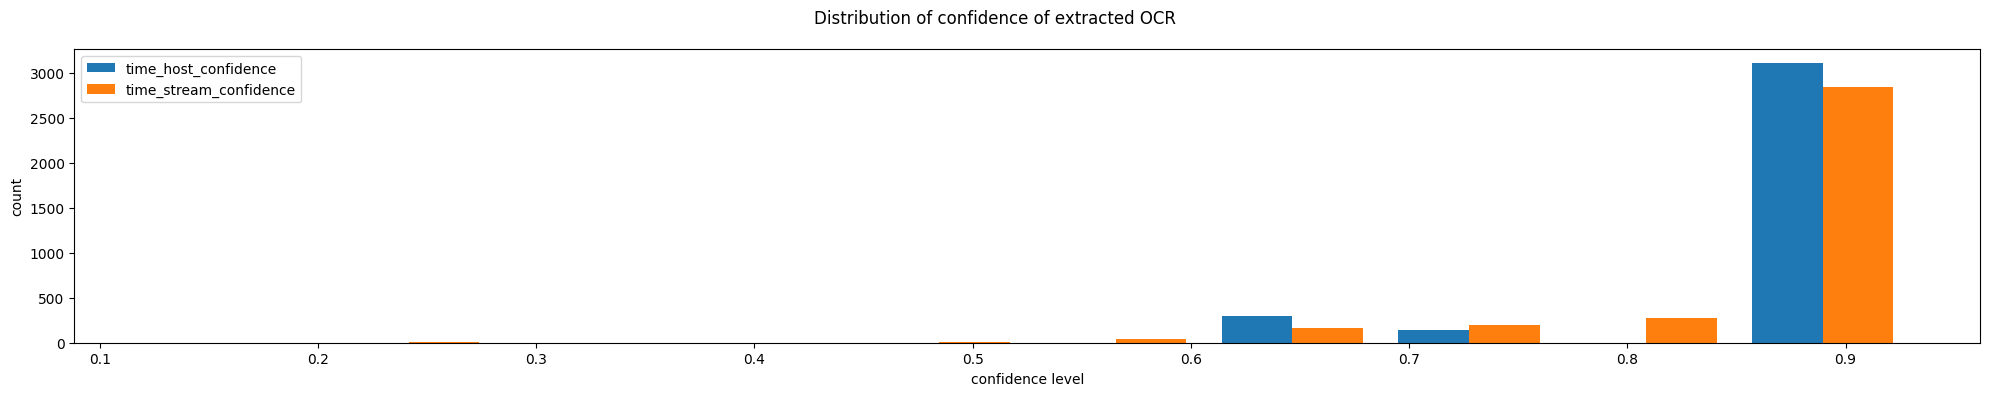

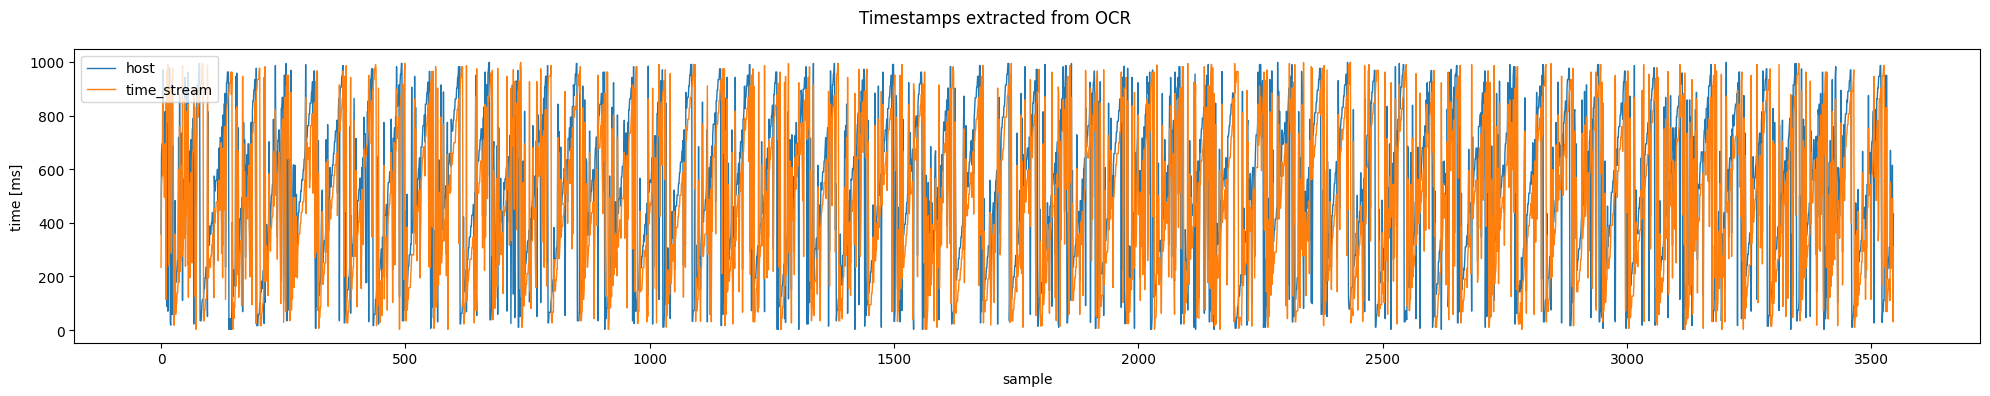

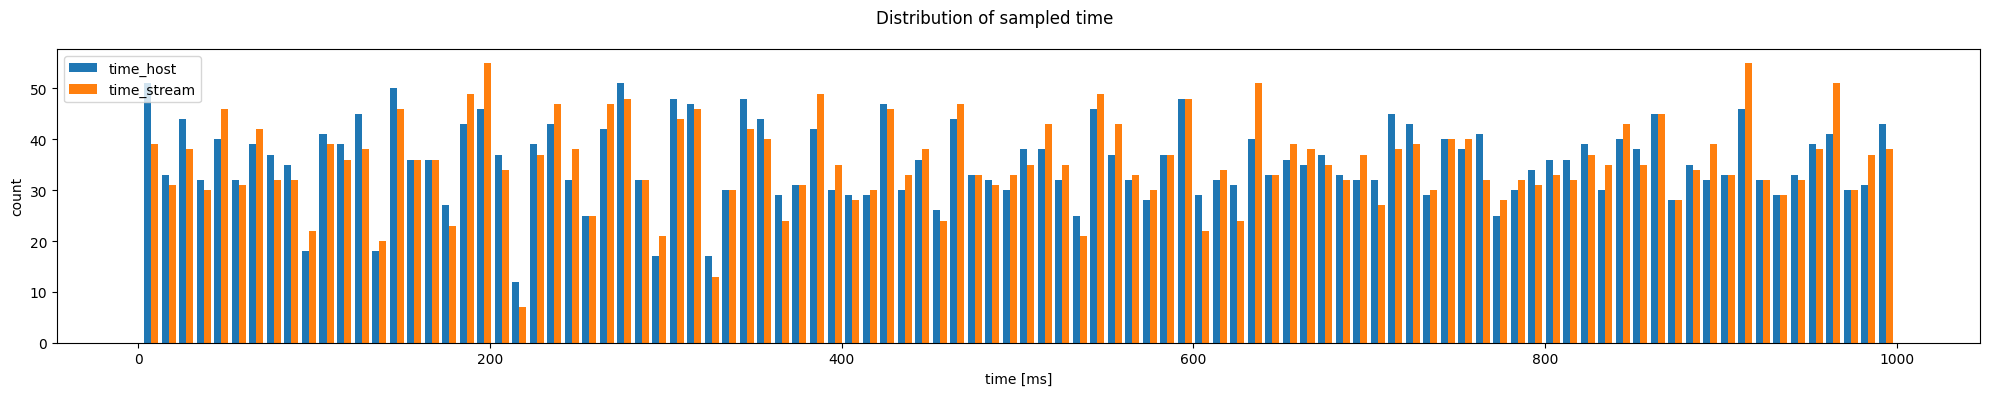

In [85]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,4))

plt.suptitle('Distribution of confidence of extracted OCR')
plt.xlabel('confidence level')
plt.ylabel('count')

cols = ['time_host_confidence', 'time_stream_confidence']
plt.hist(df[cols], 10, histtype='bar', label=cols)

plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

plt.figure(figsize=(20,4))

plt.suptitle('Timestamps extracted from OCR')
plt.xlabel('sample')
plt.ylabel('time [ms]')

plt.plot(df.index, df['time_host'], label='host', lw=1)
plt.plot(df.index, df['time_stream'], label='time_stream', lw=1)

plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

plt.figure(figsize=(20,4))

plt.suptitle('Distribution of sampled time')
plt.xlabel('time [ms]')
plt.ylabel('count')

cols = ['time_host', 'time_stream']
plt.hist(df[cols], 100, histtype='bar', label=cols)

plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

In [86]:
# Filter out low-confidence values
confidence_threshold = df.quantile(0.60, interpolation='linear')['time_stream_confidence']

print(f'Length before filtering out values with confidence lower than {confidence_threshold}:', len(df))
df = df.loc[df['time_host_confidence'] >= confidence_threshold]
df = df.loc[df['time_stream_confidence'] >= confidence_threshold]
print(f'Length after filtering out values with confidence lower than {confidence_threshold}:', len(df))

df.describe()

Length before filtering out values with confidence lower than 0.9: 3546
Length after filtering out values with confidence lower than 0.9: 1352


,time_stream_confidence,time_host_confidence,time_stream,time_host,delay_stream,jitter_stream
count,1352.000000,1352.000000,1352.000000,1352.000000,1352.000000,1352.000000
mean,0.906302,0.902130,545.930522,526.911316,207.672545,165.431620
std,0.006163,0.004376,287.032398,304.536078,261.749922,203.107833
min,0.900000,0.900000,2.628107,2.534925,79.424311,32.269054
25%,0.900000,0.900000,316.209575,258.196281,83.681303,74.405574
50%,0.910000,0.900000,576.492403,566.461275,120.206730,76.547012
75%,0.910000,0.900000,786.753423,802.431282,123.951496,116.183766
max,0.930000,0.920000,998.594847,998.247763,920.254931,723.876376


In [87]:
# Filter out outliers
from scipy import stats

# Compute Z-score for each column
z = np.abs(stats.zscore(df))

# Define threshold for outlier detection
z_score_threshold = 1.5

print(f'Length before filtering by z-score of {z_score_threshold}:', len(df))

# Filter out rows with any values above threshold
df = df.loc[(z < z_score_threshold).all(axis=1)]

print(f'Length after filtering by z-score of {z_score_threshold}:', len(df))

df.reset_index(drop=True)

df.describe()

Length before filtering by z-score of 1.5: 1352
Length after filtering by z-score of 1.5: 728


,time_stream_confidence,time_host_confidence,time_stream,time_host,delay_stream,jitter_stream
count,728.000000,728.0,728.000000,728.000000,728.000000,728.000000
mean,0.905000,0.9,566.299599,674.724333,108.424733,87.953821
std,0.005003,0.0,206.480903,204.944134,19.945542,19.945542
min,0.900000,0.9,116.240512,198.558477,79.473835,32.401174
25%,0.900000,0.9,416.544889,518.568193,82.313306,74.251661
50%,0.905000,0.9,582.391443,690.823099,120.058133,76.320422
75%,0.910000,0.9,750.536134,850.800484,122.126894,114.065249
max,0.910000,0.9,902.415488,982.710845,163.977381,116.904720


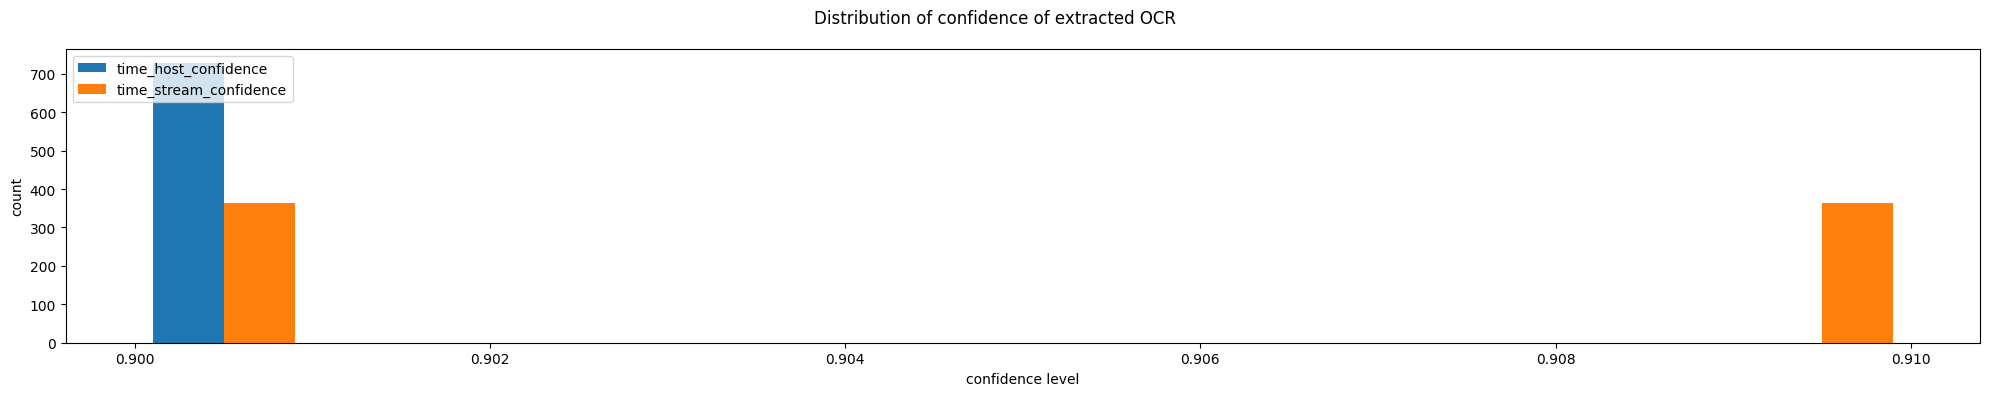

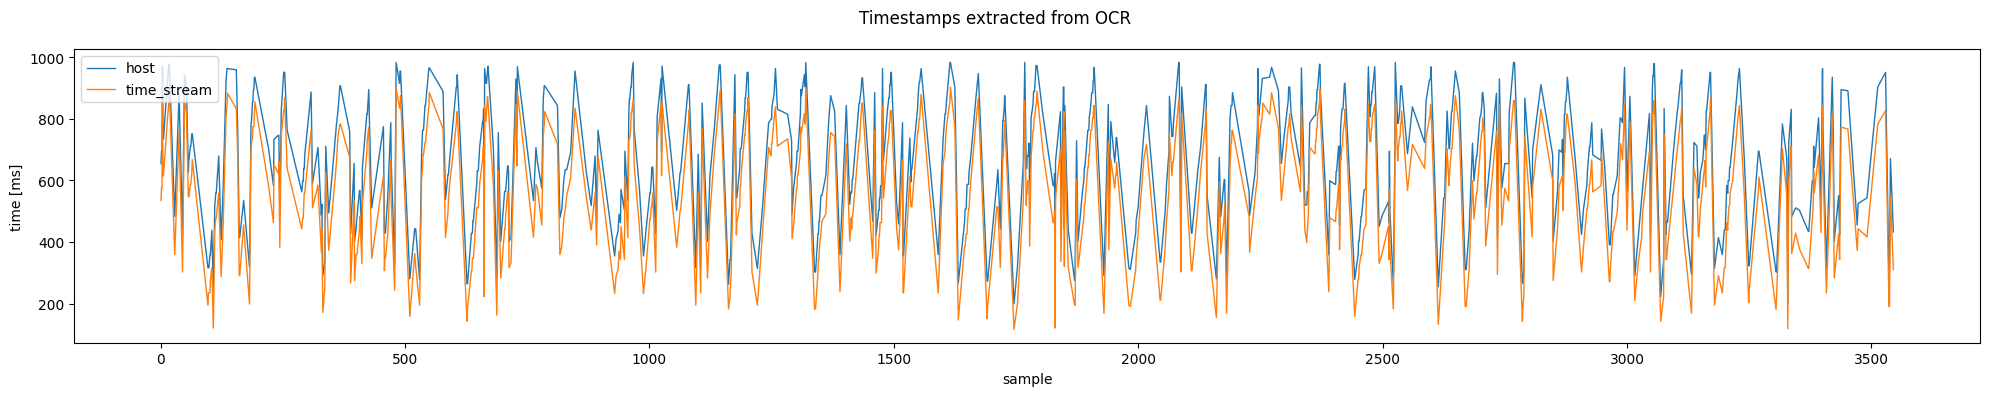

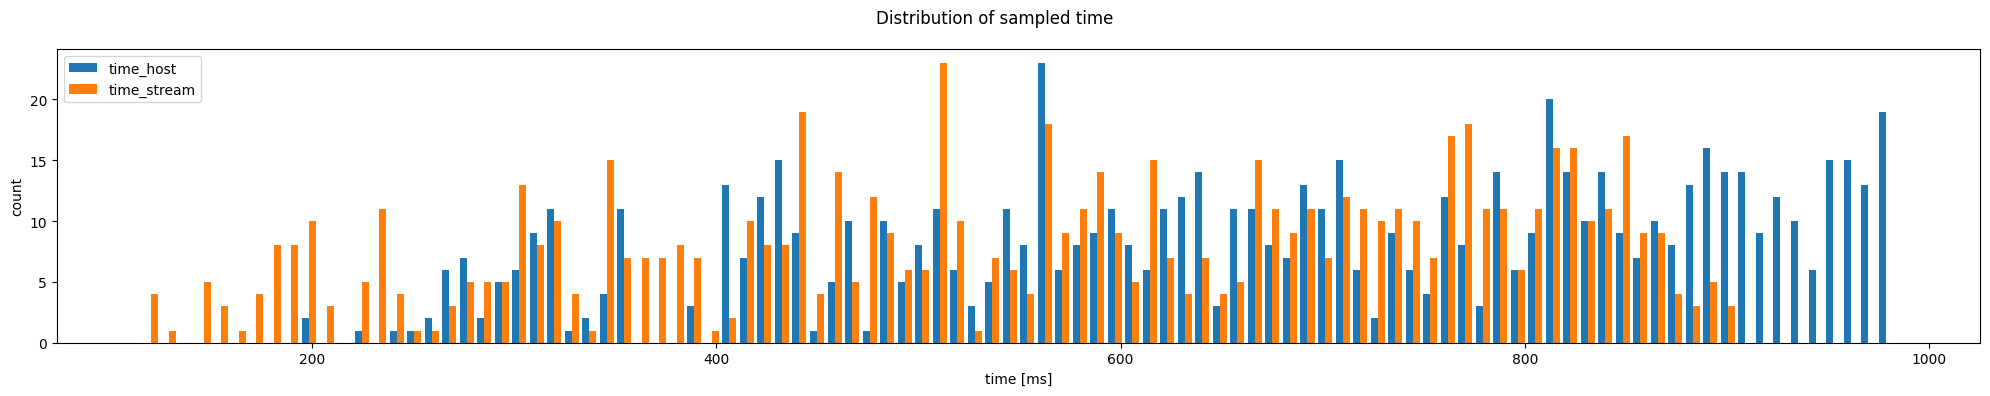

In [88]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,4))

plt.suptitle('Distribution of confidence of extracted OCR')
plt.xlabel('confidence level')
plt.ylabel('count')

cols = ['time_host_confidence', 'time_stream_confidence']
plt.hist(df[cols], 10, histtype='bar', label=cols)

plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

plt.figure(figsize=(20,4))

plt.suptitle('Timestamps extracted from OCR')
plt.xlabel('sample')
plt.ylabel('time [ms]')

plt.plot(df.index, df['time_host'], label='host', lw=1)
plt.plot(df.index, df['time_stream'], label='time_stream', lw=1)

plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

plt.figure(figsize=(20,4))

plt.suptitle('Distribution of sampled time')
plt.xlabel('time [ms]')
plt.ylabel('count')

cols = ['time_host', 'time_stream']
plt.hist(df[cols], 100, histtype='bar', label=cols)

plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

In [90]:
df_udp = (
    df[['delay_stream', 'jitter_stream']]
    .reset_index(drop=True)
)
df_udp.to_csv("brcam_udp.csv")
df_udp

,delay_stream,jitter_stream
0,119.532502,76.846053
1,119.975282,76.403273
2,119.975282,76.403273
3,120.141516,76.237039
4,119.537873,76.840682
...,...,...
723,123.970281,72.408274
724,80.224137,116.154418
725,120.326958,76.051597
726,119.467057,76.911498


## RTSP


In [11]:
numbers_rtsp = extract_numbers_parallel('extracted_images/brcam_rtsp/img*.png', 60)

100%|██████████| 3942/3942 [02:05<00:00, 31.51it/s]


In [12]:
df = numbers_to_dataframe(numbers_rtsp)

df = df.set_index('filename', drop=True).sort_index().reset_index(drop=True)

# Scale to milliseconds (from an 9-digits number after the seconds comma)
df['1_value'] = df['1_value'] * 1e-6
df['0_value'] = df['0_value'] * 1e-6

# Compute latencies - because time is warping each second, we get the absolute values
df['0_delay'] = np.abs(df['1_value'] - df['0_value'])

# Computed jitter
df['0_jitter'] = np.abs(df['0_delay'].mean() - df['0_delay'])

df = df.rename(columns={
    '0_confidence': 'time_stream_confidence',
    '1_confidence': 'time_host_confidence',
    '0_value': 'time_stream',
    '1_value': 'time_host',
    '0_delay': 'delay_stream',
    '0_jitter': 'jitter_stream',
})

df.describe()


,time_stream_confidence,time_host_confidence,time_stream,time_host,delay_stream,jitter_stream
count,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000
mean,0.876760,0.900090,495.942124,498.137316,231.800680,170.456945
std,0.071671,0.006279,288.170432,288.225909,249.852278,182.655704
min,0.220000,0.880000,2.231597,2.202968,19.720604,17.737003
25%,0.890000,0.900000,246.646318,250.236202,120.244814,71.966141
50%,0.900000,0.900000,494.314224,494.671830,124.159181,109.701482
75%,0.910000,0.900000,742.517533,746.415702,162.410163,111.934037
max,0.930000,0.920000,998.683863,998.683863,979.678869,747.878189


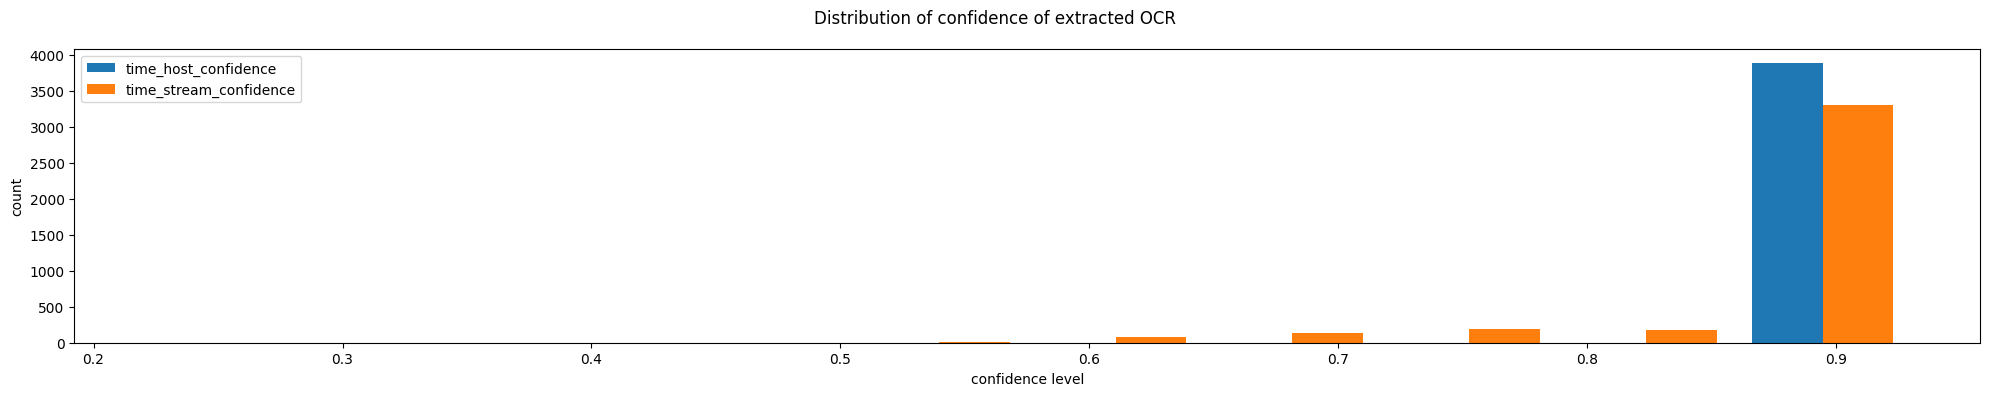

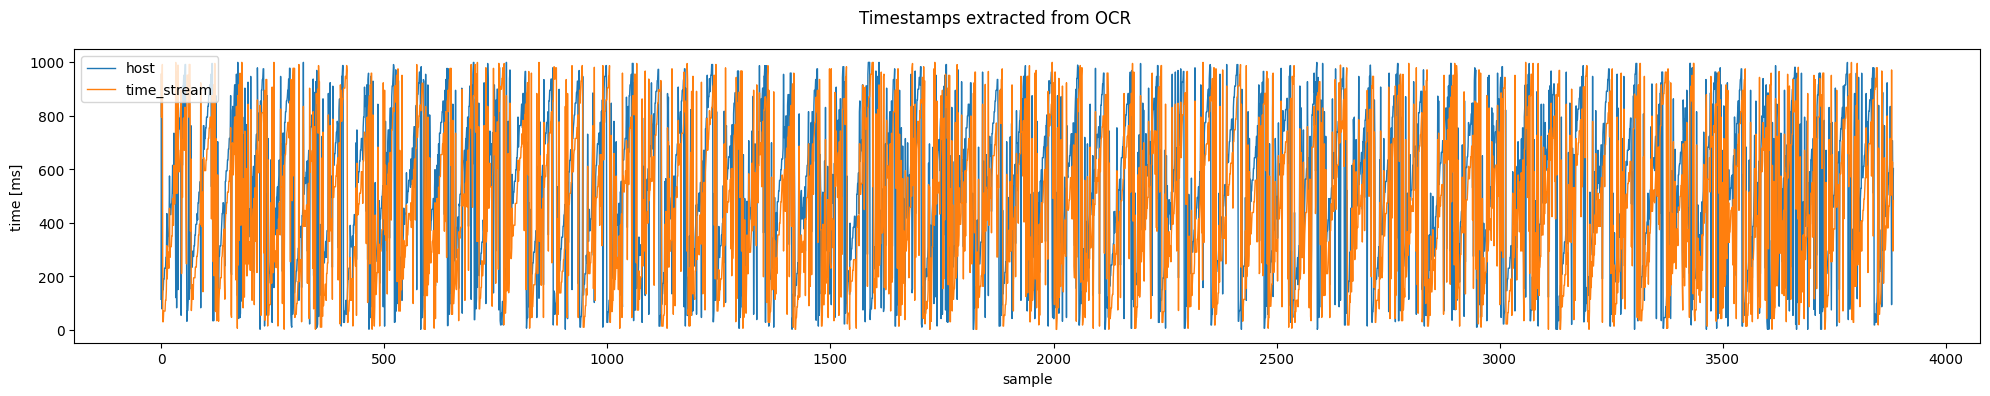

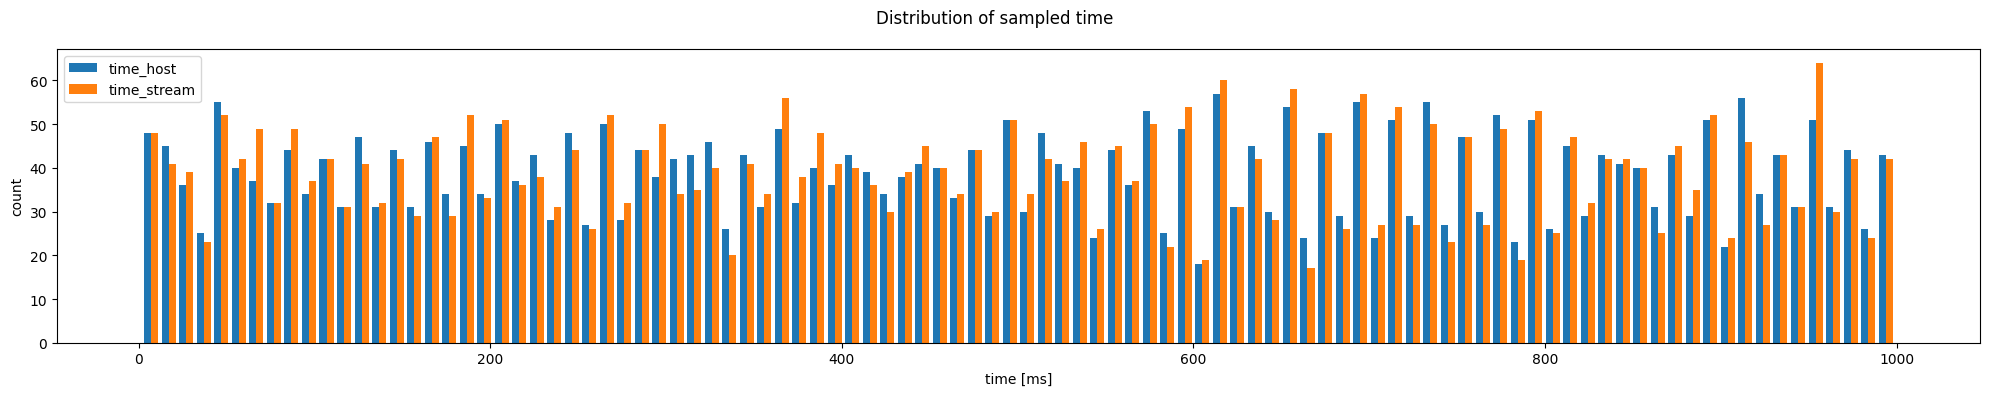

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,4))

plt.suptitle('Distribution of confidence of extracted OCR')
plt.xlabel('confidence level')
plt.ylabel('count')

cols = ['time_host_confidence', 'time_stream_confidence']
plt.hist(df[cols], 10, histtype='bar', label=cols)

plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

plt.figure(figsize=(20,4))

plt.suptitle('Timestamps extracted from OCR')
plt.xlabel('sample')
plt.ylabel('time [ms]')

plt.plot(df.index, df['time_host'], label='host', lw=1)
plt.plot(df.index, df['time_stream'], label='time_stream', lw=1)

plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

plt.figure(figsize=(20,4))

plt.suptitle('Distribution of sampled time')
plt.xlabel('time [ms]')
plt.ylabel('count')

cols = ['time_host', 'time_stream']
plt.hist(df[cols], 100, histtype='bar', label=cols)

plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

In [14]:
# Filter out low-confidence values
confidence_threshold = df.quantile(0.60, interpolation='linear')['time_stream_confidence']

print(f'Length before filtering out values with confidence lower than {confidence_threshold}:', len(df))
df = df.loc[df['time_host_confidence'] >= confidence_threshold]
df = df.loc[df['time_stream_confidence'] >= confidence_threshold]
print(f'Length after filtering out values with confidence lower than {confidence_threshold}:', len(df))

df.describe()

Length before filtering out values with confidence lower than 0.9: 3883
Length after filtering out values with confidence lower than 0.9: 2345


,time_stream_confidence,time_host_confidence,time_stream,time_host,delay_stream,jitter_stream
count,2345.000000,2345.000000,2345.000000,2345.000000,2345.000000,2345.000000
mean,0.906038,0.902171,490.226110,499.361655,225.821122,164.344282
std,0.006227,0.004593,286.017157,285.158211,241.958794,177.649269
min,0.900000,0.900000,2.231597,2.231597,79.531394,23.488936
25%,0.900000,0.900000,238.472227,250.739893,120.298927,71.940999
50%,0.910000,0.900000,490.602074,510.205916,124.140687,109.550597
75%,0.910000,0.900000,726.602455,746.453716,162.193173,111.859832
max,0.930000,0.920000,998.683863,998.683863,920.366100,688.565420


In [15]:
# Filter out outliers
from scipy import stats

# Compute Z-score for each column
z = np.abs(stats.zscore(df))

# Define threshold for outlier detection
z_score_threshold = 1.5

print(f'Length before filtering by z-score of {z_score_threshold}:', len(df))

# Filter out rows with any values above threshold
df = df.loc[(z < z_score_threshold).all(axis=1)]

print(f'Length after filtering by z-score of {z_score_threshold}:', len(df))

df.reset_index(drop=True)

df.describe()

Length before filtering by z-score of 1.5: 2345
Length after filtering by z-score of 1.5: 1311


,time_stream_confidence,time_host_confidence,time_stream,time_host,delay_stream,jitter_stream
count,1311.000000,1311.0,1311.000000,1311.000000,1311.000000,1311.000000
mean,0.904928,0.9,434.415251,568.394924,133.979673,97.821006
std,0.005001,0.0,211.927291,212.575306,20.233248,20.233248
min,0.900000,0.9,62.475065,182.282410,79.531394,32.088763
25%,0.900000,0.9,250.510437,382.586772,120.204939,71.799571
50%,0.900000,0.9,446.661439,574.676196,123.849705,107.950975
75%,0.910000,0.9,614.697791,754.185603,160.001109,111.595741
max,0.910000,0.9,842.458984,926.666009,199.711917,152.269286


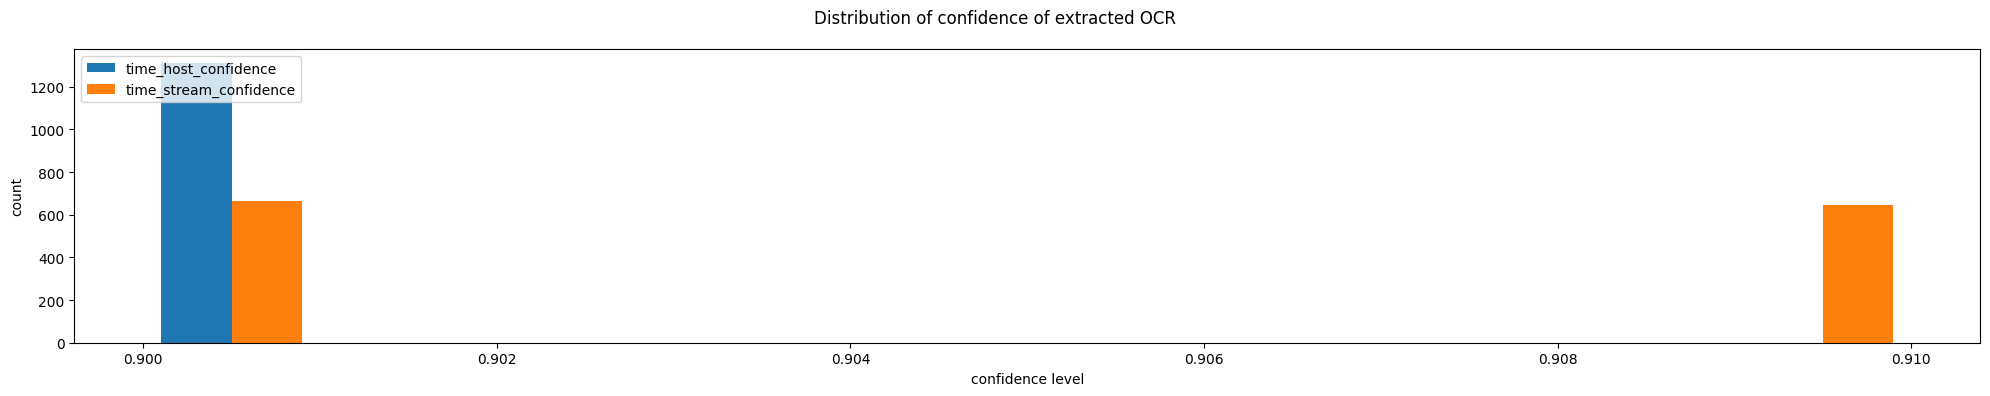

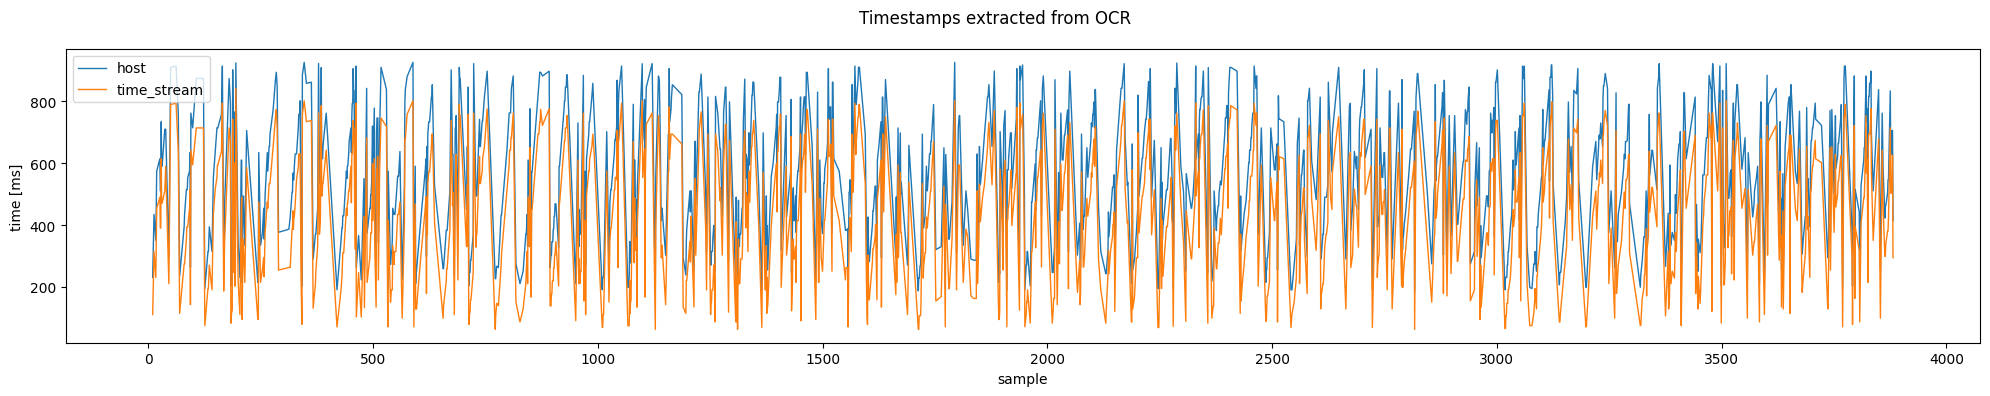

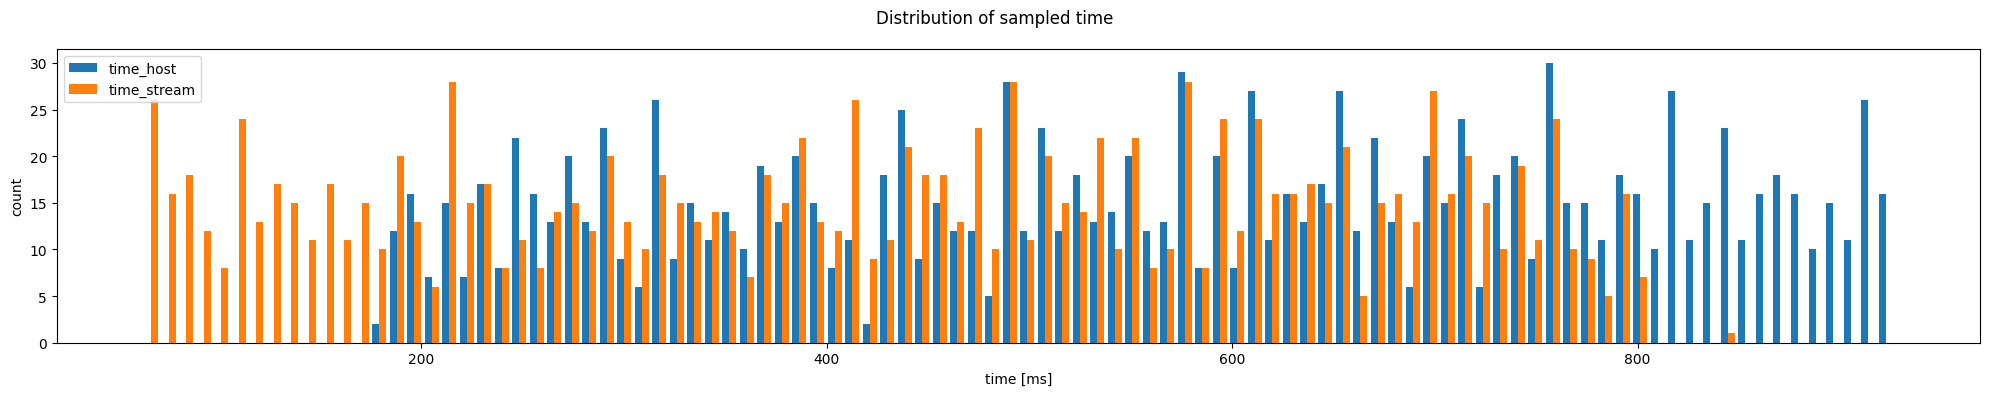

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,4))

plt.suptitle('Distribution of confidence of extracted OCR')
plt.xlabel('confidence level')
plt.ylabel('count')

cols = ['time_host_confidence', 'time_stream_confidence']
plt.hist(df[cols], 10, histtype='bar', label=cols)

plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

plt.figure(figsize=(20,4))

plt.suptitle('Timestamps extracted from OCR')
plt.xlabel('sample')
plt.ylabel('time [ms]')

plt.plot(df.index, df['time_host'], label='host', lw=1)
plt.plot(df.index, df['time_stream'], label='time_stream', lw=1)

plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

plt.figure(figsize=(20,4))

plt.suptitle('Distribution of sampled time')
plt.xlabel('time [ms]')
plt.ylabel('count')

cols = ['time_host', 'time_stream']
plt.hist(df[cols], 100, histtype='bar', label=cols)

plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

In [17]:
df_rtsp = (
    df[['delay_stream', 'jitter_stream']]
    .reset_index(drop=True)
)
df_rtsp.to_csv("brcam_rtsp.csv")
df_rtsp

,delay_stream,jitter_stream
0,120.104157,111.696523
1,119.921190,111.879490
2,120.270884,111.529796
3,120.480040,111.320640
4,123.986074,107.814606
...,...,...
1306,123.484513,108.316167
1307,163.799226,68.001454
1308,159.972575,71.828105
1309,79.977250,151.823430


## WebRTC


In [18]:
numbers_webrtc = extract_numbers_parallel('extracted_images/brcam_webrtc/img*.png', 25)

100%|██████████| 3656/3656 [01:47<00:00, 34.12it/s]


In [19]:
df = numbers_to_dataframe(numbers_webrtc)

df = df.set_index('filename', drop=True).sort_index().reset_index(drop=True)

# Scale to milliseconds (from an 9-digits number after the seconds comma)
df['1_value'] = df['1_value'] * 1e-6
df['0_value'] = df['0_value'] * 1e-6

# Compute latencies - because time is warping each second, we get the absolute values
df['0_delay'] = np.abs(df['1_value'] - df['0_value'])

# Computed jitter
df['0_jitter'] = np.abs(df['0_delay'].mean() - df['0_delay'])

df = df.rename(columns={
    '0_confidence': 'time_stream_confidence',
    '1_confidence': 'time_host_confidence',
    '0_value': 'time_stream',
    '1_value': 'time_host',
    '0_delay': 'delay_stream',
    '0_jitter': 'jitter_stream',
})

df.describe()


,time_stream_confidence,time_host_confidence,time_stream,time_host,delay_stream,jitter_stream
count,3555.000000,3555.000000,3555.000000,3555.000000,3555.000000,3555.000000
mean,0.847412,0.869496,501.246393,500.773044,212.813946,166.161948
std,0.091543,0.073461,288.552901,288.935393,251.122823,188.268719
min,0.170000,0.650000,2.312643,2.419909,7.721775,2.467407
25%,0.810000,0.890000,254.664424,250.357173,119.737034,89.067680
50%,0.900000,0.900000,490.846280,502.818404,121.616490,92.734097
75%,0.910000,0.900000,750.493353,752.528363,159.716431,131.263371
max,0.930000,0.920000,998.909856,998.909850,980.053197,767.239251


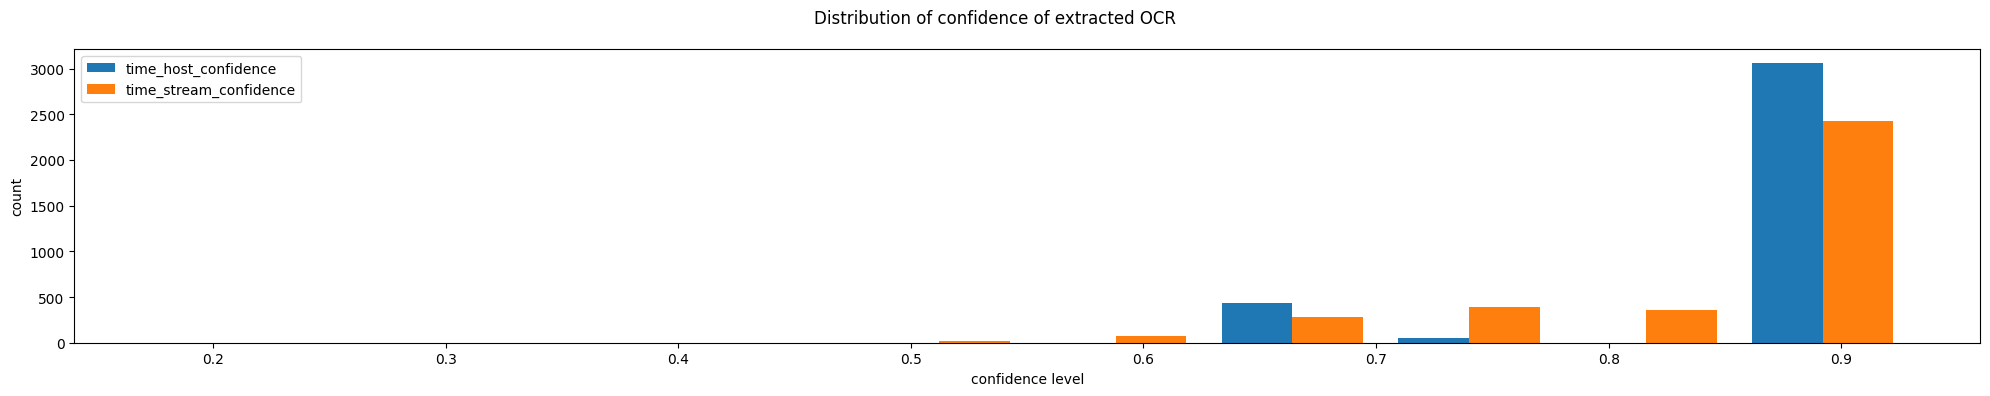

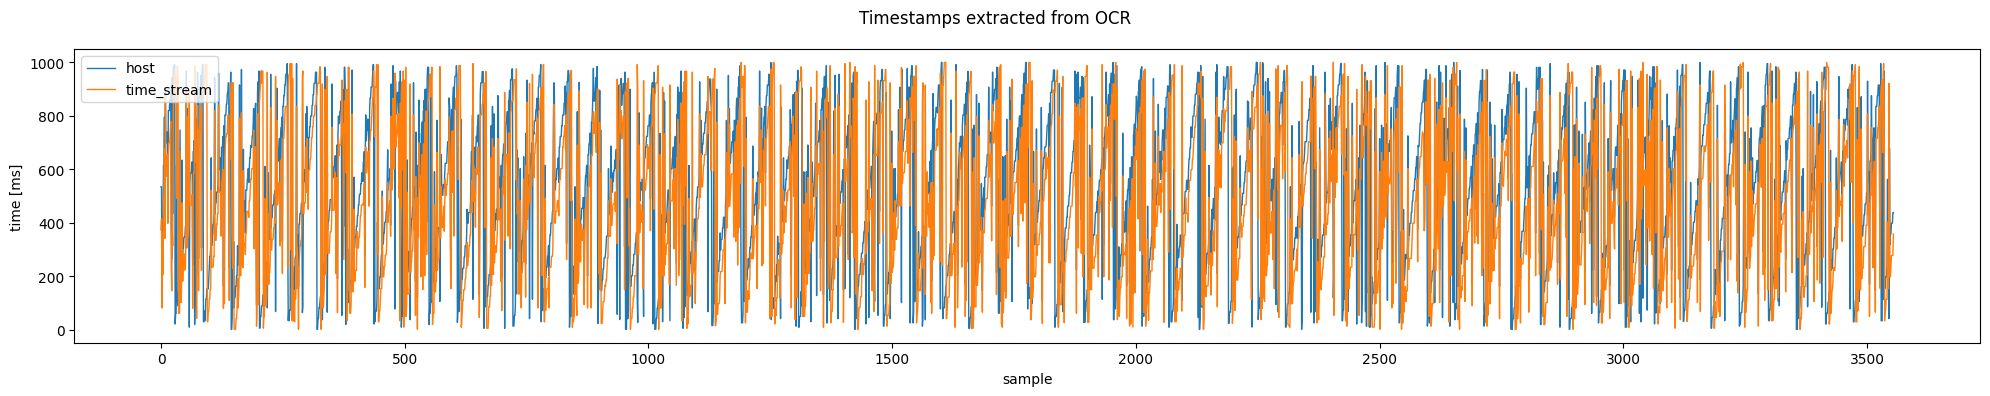

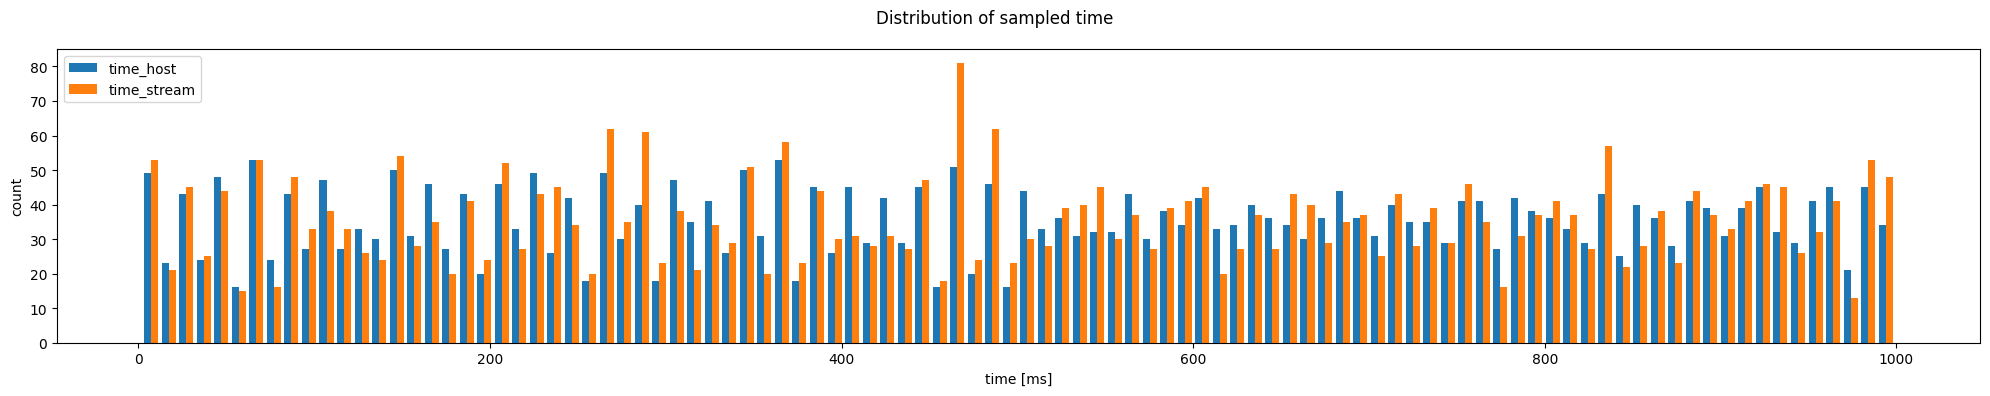

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,4))

plt.suptitle('Distribution of confidence of extracted OCR')
plt.xlabel('confidence level')
plt.ylabel('count')

cols = ['time_host_confidence', 'time_stream_confidence']
plt.hist(df[cols], 10, histtype='bar', label=cols)

plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

plt.figure(figsize=(20,4))

plt.suptitle('Timestamps extracted from OCR')
plt.xlabel('sample')
plt.ylabel('time [ms]')

plt.plot(df.index, df['time_host'], label='host', lw=1)
plt.plot(df.index, df['time_stream'], label='time_stream', lw=1)

plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

plt.figure(figsize=(20,4))

plt.suptitle('Distribution of sampled time')
plt.xlabel('time [ms]')
plt.ylabel('count')

cols = ['time_host', 'time_stream']
plt.hist(df[cols], 100, histtype='bar', label=cols)

plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

In [21]:
# Filter out low-confidence values
confidence_threshold = df.quantile(0.60, interpolation='linear')['time_stream_confidence']

print(f'Length before filtering out values with confidence lower than {confidence_threshold}:', len(df))
df = df.loc[df['time_host_confidence'] >= confidence_threshold]
df = df.loc[df['time_stream_confidence'] >= confidence_threshold]
print(f'Length after filtering out values with confidence lower than {confidence_threshold}:', len(df))

df.describe()

Length before filtering out values with confidence lower than 0.9: 3555
Length after filtering out values with confidence lower than 0.9: 1312


,time_stream_confidence,time_host_confidence,time_stream,time_host,delay_stream,jitter_stream
count,1312.000000,1312.000000,1312.000000,1312.000000,1312.000000,1312.000000
mean,0.906098,0.901540,561.799369,533.742846,233.179298,177.285814
std,0.006014,0.003694,277.392408,301.762971,269.744831,204.262340
min,0.900000,0.900000,2.567451,2.419909,79.489154,44.880470
25%,0.900000,0.900000,366.460086,260.355826,119.940354,88.979553
50%,0.910000,0.900000,587.634293,563.629194,122.000318,92.657002
75%,0.910000,0.900000,802.580010,795.587301,159.894827,130.608365
max,0.930000,0.920000,998.909850,998.909850,920.273707,707.459761


In [22]:
# Filter out outliers
from scipy import stats

# Compute Z-score for each column
z = np.abs(stats.zscore(df))

# Define threshold for outlier detection
z_score_threshold = 1.5

print(f'Length before filtering by z-score of {z_score_threshold}:', len(df))

# Filter out rows with any values above threshold
df = df.loc[(z < z_score_threshold).all(axis=1)]

print(f'Length after filtering by z-score of {z_score_threshold}:', len(df))

df.reset_index(drop=True)

df.describe()

Length before filtering by z-score of 1.5: 1312
Length after filtering by z-score of 1.5: 749


,time_stream_confidence,time_host_confidence,time_stream,time_host,delay_stream,jitter_stream
count,749.000000,7.490000e+02,749.000000,749.000000,749.000000,749.000000
mean,0.905340,9.000000e-01,560.408858,680.278178,119.869320,92.944626
std,0.004992,1.110965e-16,191.898798,191.447125,22.941702,22.941702
min,0.900000,9.000000e-01,146.564745,230.832388,79.489154,45.041284
25%,0.900000,9.000000e-01,398.432246,520.261190,119.764932,88.838154
50%,0.910000,9.000000e-01,562.877683,682.762921,120.319183,92.494763
75%,0.910000,9.000000e-01,734.265013,850.613500,123.975792,93.049014
max,0.910000,9.000000e-01,898.801167,982.999002,167.772662,133.324792


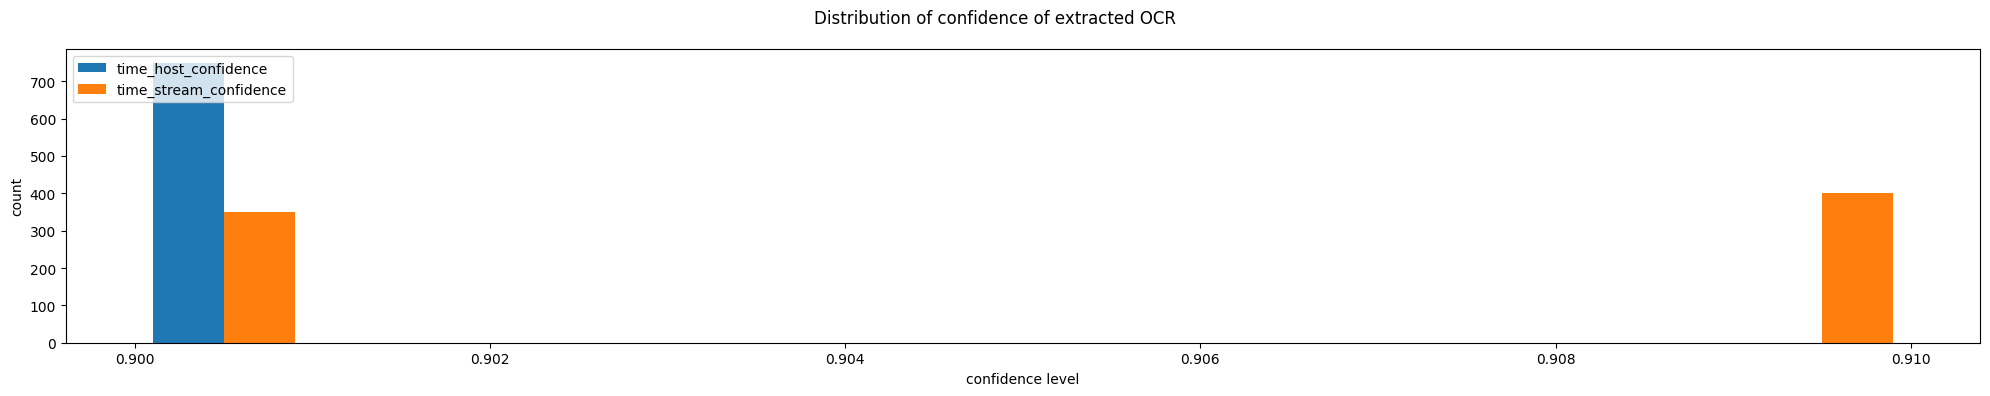

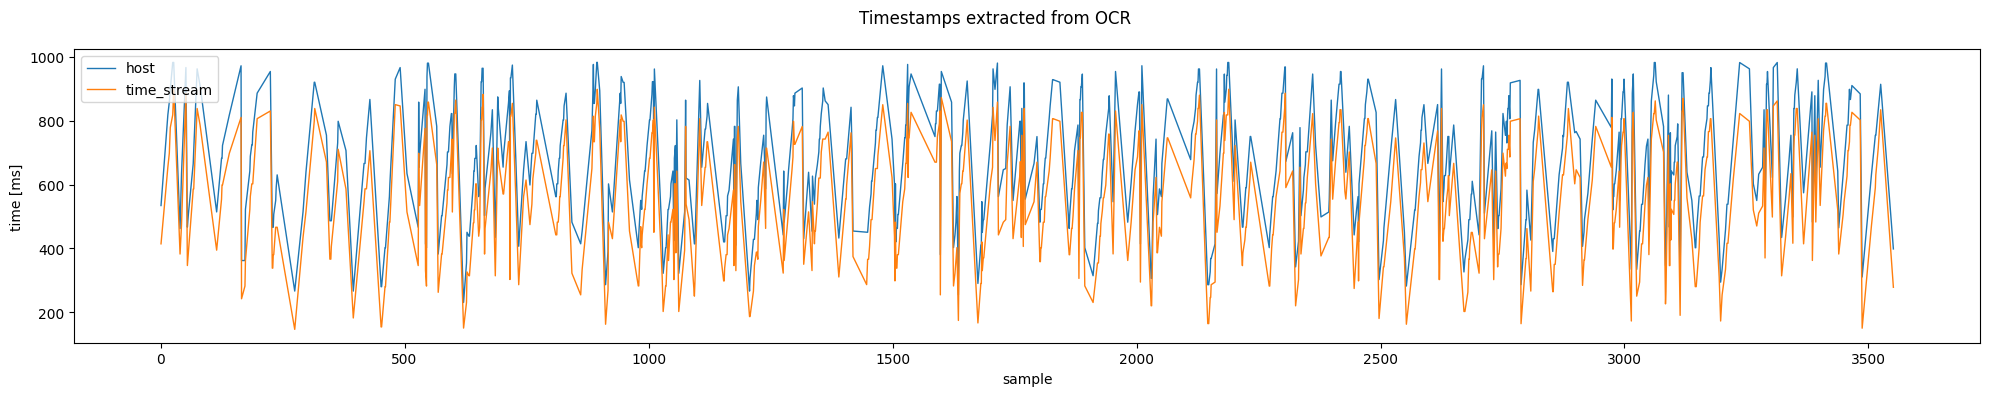

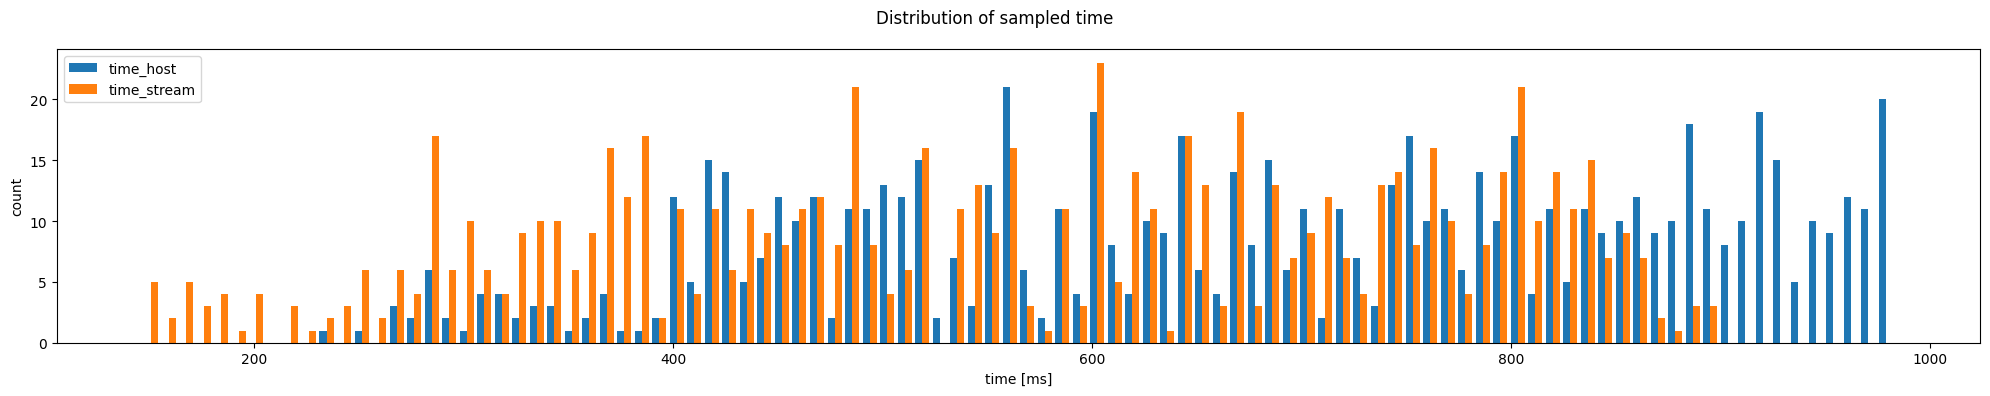

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,4))

plt.suptitle('Distribution of confidence of extracted OCR')
plt.xlabel('confidence level')
plt.ylabel('count')

cols = ['time_host_confidence', 'time_stream_confidence']
plt.hist(df[cols], 10, histtype='bar', label=cols)

plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

plt.figure(figsize=(20,4))

plt.suptitle('Timestamps extracted from OCR')
plt.xlabel('sample')
plt.ylabel('time [ms]')

plt.plot(df.index, df['time_host'], label='host', lw=1)
plt.plot(df.index, df['time_stream'], label='time_stream', lw=1)

plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

plt.figure(figsize=(20,4))

plt.suptitle('Distribution of sampled time')
plt.xlabel('time [ms]')
plt.ylabel('count')

cols = ['time_host', 'time_stream']
plt.hist(df[cols], 100, histtype='bar', label=cols)

plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

In [24]:
df_webrtc = (
    df[['delay_stream', 'jitter_stream']]
    .reset_index(drop=True)
)
df_webrtc.to_csv("brcam_webrtc.csv")
df_webrtc

,delay_stream,jitter_stream
0,119.992554,92.821392
1,163.910063,48.903883
2,160.362530,52.451416
3,120.039392,92.774554
4,164.275144,48.538802
...,...,...
744,163.985837,48.828109
745,123.914445,88.899501
746,119.840485,92.973461
747,79.749888,133.064058


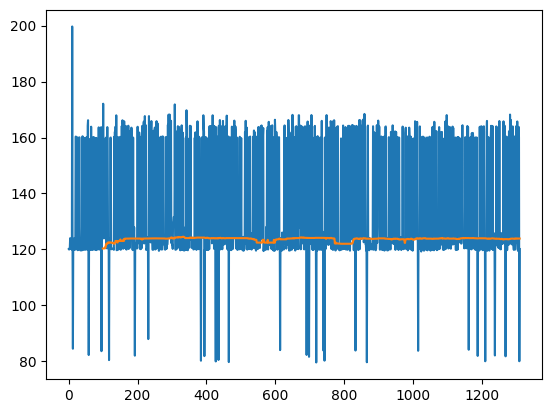

In [73]:
df = df_rtsp.copy()

filt_size = 100
df = df.rolling(filt_size, closed='both', center=False).median()

plt.plot(df.index, df_rtsp['delay_stream'])
plt.plot(df.index, df['delay_stream'])

## COMPARISON


(79.47383500000001, 199.71191700000003)

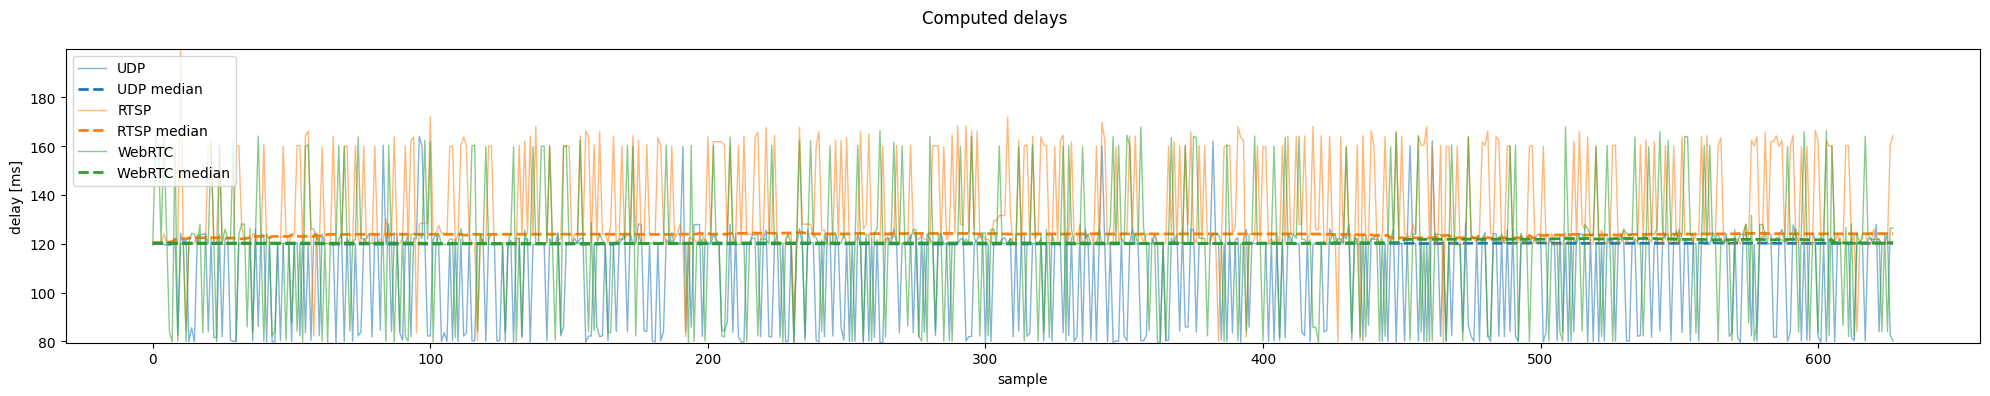

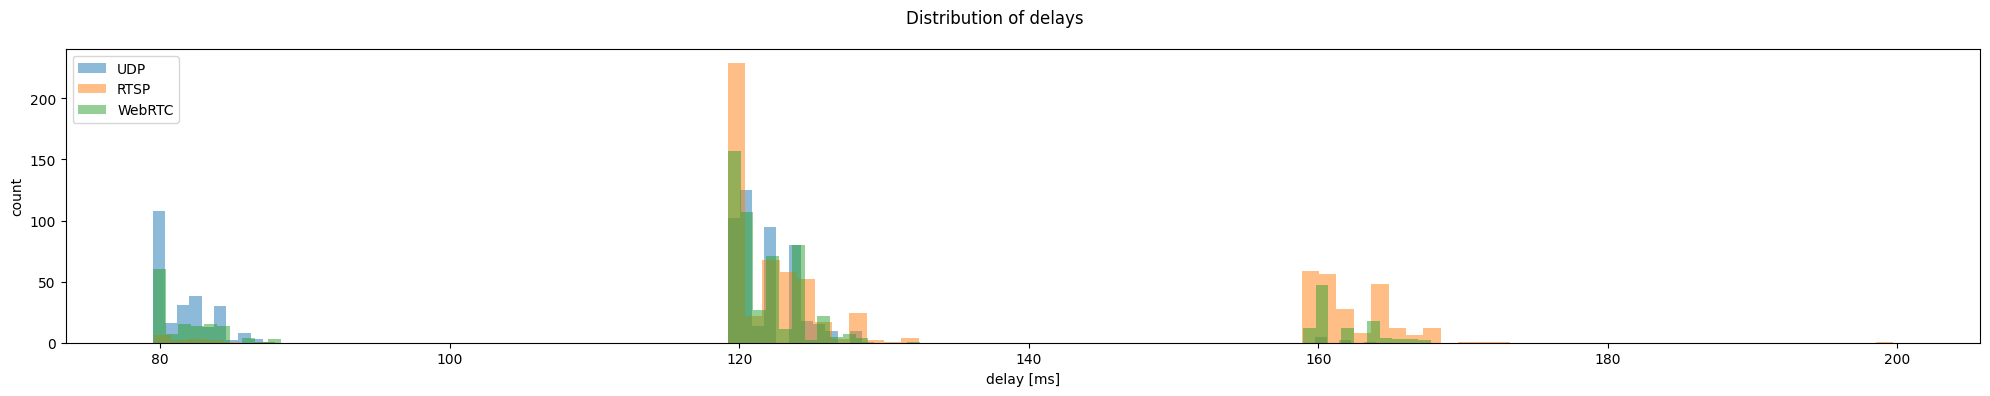

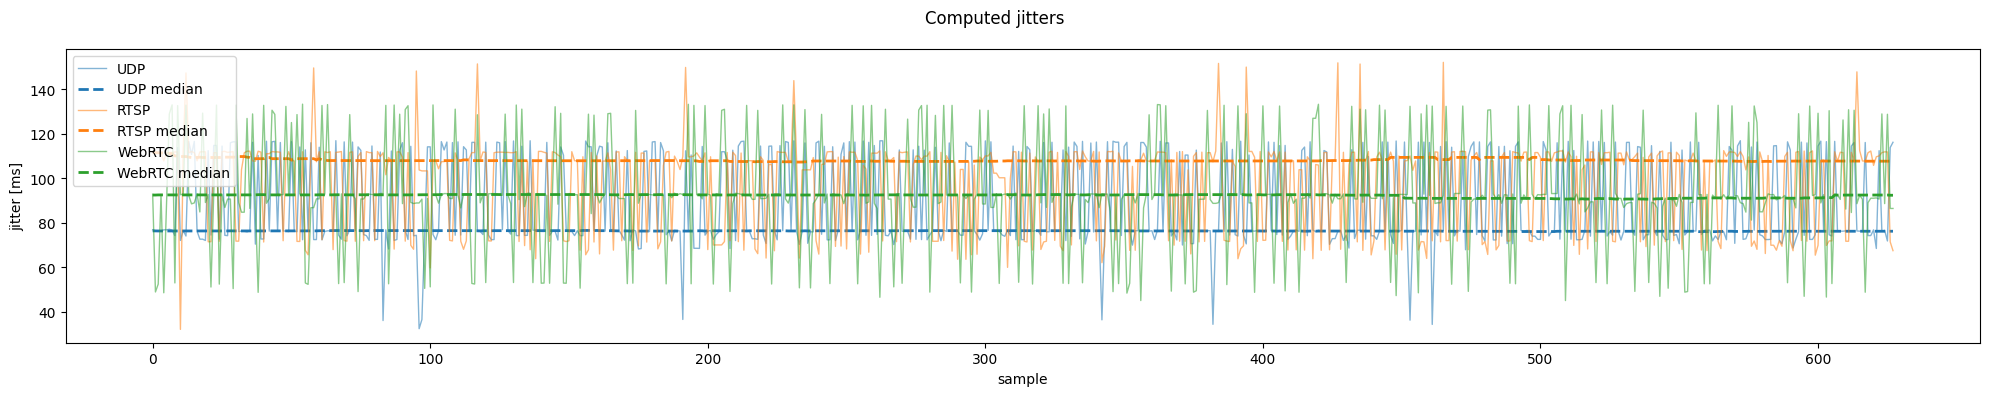

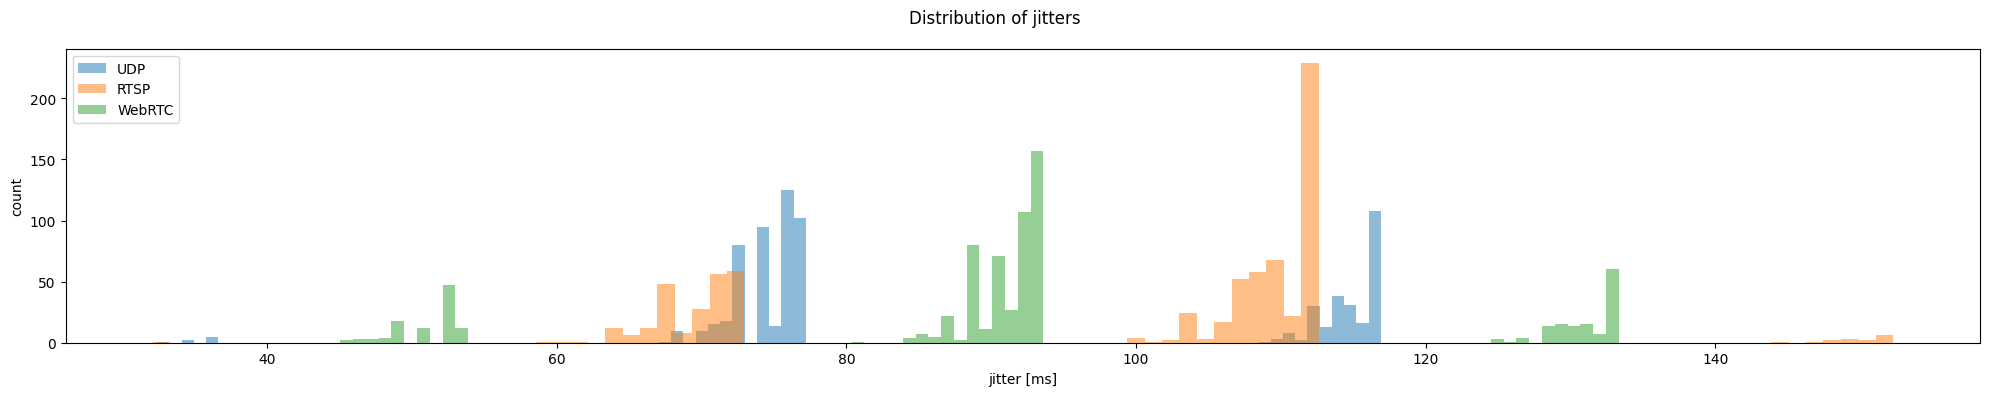

In [99]:
dfs = [("UDP", df_udp), ("RTSP", df_rtsp), ("WebRTC", df_webrtc)]

size = min([len(df) for (_, df) in dfs])
filt_size = 100

plt.figure(figsize=(20,4))

plt.suptitle('Computed delays')
plt.xlabel('sample')
plt.ylabel('delay [ms]')

for (label, df) in dfs:
    plt.plot(df.index[:size-filt_size], df['delay_stream'][:size-filt_size], label=label, lw=1, alpha=0.55)
    color = plt.gca().lines[-1].get_color()
    df = df.rolling(filt_size, closed='both', center=False).median()[filt_size:size].reset_index(drop=True)
    plt.plot(df.index, df['delay_stream'], '--', label=label+' median', lw=2, color=color)

plt.legend(loc='upper left')
plt.ylim((min([df.min()['delay_stream'] for (_, df) in dfs]), max([df.max()['delay_stream'] for (_, df) in dfs])))
plt.tight_layout()
plt.show()

plt.figure(figsize=(20,4))

plt.suptitle('Distribution of delays')
plt.xlabel('delay [ms]')
plt.ylabel('count')

for (label, df) in dfs:
    plt.hist(df['delay_stream'][:size], 100, histtype='bar', label=label, alpha=0.5)

plt.legend(loc='upper left')
plt.tight_layout()
plt.show()


plt.figure(figsize=(20,4))

plt.suptitle('Computed jitters')
plt.xlabel('sample')
plt.ylabel('jitter [ms]')

for (label, df) in dfs:
    plt.plot(df.index[:size-filt_size], df['jitter_stream'][:size-filt_size], label=label, lw=1, alpha=0.55)
    color = plt.gca().lines[-1].get_color()
    df = df.rolling(filt_size, closed='both', center=False).median()[filt_size:size].reset_index(drop=True)
    plt.plot(df.index, df['jitter_stream'], '--', label=label+' median', lw=2, color=color)

plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

plt.figure(figsize=(20,4))

plt.suptitle('Distribution of jitters')
plt.xlabel('jitter [ms]')
plt.ylabel('count')

for (label, df) in dfs:
    plt.hist(df['jitter_stream'][:size], 100, histtype='bar', label=label, alpha=0.5)

plt.legend(loc='upper left')
plt.tight_layout()
plt.show()